
# Sage Maker Exercise
---
## Introduction
This notebook demonstrates how to run a training job with a custom script in SageMaker using the SKLearn framework. The custom script also contains *helper functions* which handle custom prediction capabilities

We will use the [Titanic - Machine Learning From Disaster](https://www.kaggle.com/competitions/titanic/data). We will be using Logistic Regression to predict the survival of a person

---
## Prerequisites
- Retrieve the default role assigned to the SageMaker Studio. We will use this to interact with other SageMaker and AWS services
- Set the S3 bucket to use for storing the training artifacts

In [79]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
from tensorflow import keras


# Load Dataset
 - PassengerId: A unique identifier for each passenger
 - Survived: A binary variable indicating whether the passenger survived (1) or did not survive (0)
 - Pclass: A categorical variable indicating the passenger's class (1 = first class, 2 = second class, 3 = third class)
 - Name: The passenger's name
 - Sex: The passenger's gender (male or female)
 - Age: The passenger's age
 - SibSp: The number of siblings or spouses the passenger had on board
 - Parch: The number of parents or children the passenger had on board
 - Ticket: The passenger's ticket number
 - Fare: The fare the passenger paid for their ticket
 - Cabin: The passenger's cabin number
 - Embarked: The port from which the passenger embarked (C = Cherbourg, Q = Queenstown, S = Southampton)

In [ ]:
import boto3
import sagemaker

role = sagemaker.get_execution_role()
region = boto3.Session().region_name

data_source = f's3://sagemaker-us-west-2-021454448884/galang/exercise/modified_titanic_data1.csv'

output_bucket = sagemaker.Session().default_bucket()
output_prefix = "galang/exercise"

In [80]:

df = pd.read_csv("modified_titanic_data1.csv")
# .head shows the first n rows of the dataset, default 10
df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female   -      1   
2                             Heikkinen, Miss. Laina  female  26      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  na      1   
4                           Allen, Mr. William Henry    male  35      0   

   Parch            Ticket     Fare Cabin Embarked          OnboardTime  \
0      0         A/5 21171   7.2500   NaN        S  1912-04-10 09:42:47   
1      0          PC 17599  71.2833   C85        C  1912-04-10 09:54:01   
2      0  STON/O2. 3101282   7.9250   NaN        S  1912-04-10 09:55:37   
3      0            113803  53.1000  C123        S  1912-04-10 08:06:51   
4      0            373450   8.0500   NaN        S  1912-04-10 09:10:39   

   Unnamed: 13  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN

In [81]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            178
SibSp            0
Parch            0
Ticket           0
Fare            44
Cabin          689
Embarked         2
OnboardTime      0
Unnamed: 13    895
dtype: int64

In [82]:
#This 
df = df.drop(columns=["Unnamed: 13","Ticket"]) 
df.drop_duplicates(inplace=True)
df.head()


PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female   -      1   
2                             Heikkinen, Miss. Laina  female  26      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  na      1   
4                           Allen, Mr. William Henry    male  35      0   

   Parch     Fare Cabin Embarked          OnboardTime  
0      0   7.2500   NaN        S  1912-04-10 09:42:47  
1      0  71.2833   C85        C  1912-04-10 09:54:01  
2      0   7.9250   NaN        S  1912-04-10 09:55:37  
3      0  53.1000  C123        S  1912-04-10 08:06:51  
4      0   8.0500   NaN        S  1912-04-10 09:10:39

In [83]:
print('Number of null Pclass:')
df['Pclass'].isna().sum()


Number of null Pclass:


0

No null Pclass

In [84]:
# inspect the correlation between Pclass and Survived
df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean()

Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363

# Name

In [85]:
df['Name'].head(20)

0                               Braund, Mr. Owen Harris
1     Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                Heikkinen, Miss. Laina
3          Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                              Allen, Mr. William Henry
5                                      Moran, Mr. James
6                               McCarthy, Mr. Timothy J
7                        Palsson, Master. Gosta Leonard
8     Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                   Nasser, Mrs. Nicholas (Adele Achem)
10                      Sandstrom, Miss. Marguerite Rut
11                             Bonnell, Miss. Elizabeth
12                       Saundercock, Mr. William Henry
13                          Andersson, Mr. Anders Johan
14                 Vestrom, Miss. Hulda Amanda Adolfina
15                     Hewlett, Mrs. (Mary D Kingcome) 
16                                 Rice, Master. Eugene
17                         Williams, Mr. Charles

As we can see, there is a pattern of `LastName`,`Title` `FirstName`

Isolate the title per person

In [86]:
df.Name.map( lambda x: x.split(',')[1].split( '.' )[0].strip())

0        Mr
1       Mrs
2      Miss
3       Mrs
4        Mr
       ... 
890     Rev
891    Miss
892    Miss
893      Mr
894      Mr
Name: Name, Length: 891, dtype: object

In [87]:
df['Title'] = df.Name.map( lambda x: x.split(',')[1].split( '.' )[0].strip())

# inspect the amount of people for each title
df['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: Title, dtype: int64

Majority of the titles are Mr Miss Mrs and Master. We can change some of the titles like Ms, Sir, Lady to merge with the majority titles

In [88]:
df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace(['Mme','Lady','Ms'], 'Mrs')
title_list = df['Title'].unique().tolist()
others = [title for title in title_list if title not in ['Mrs', 'Mr','Miss','Master']]
df['Title'] = df['Title'].replace(others, 'Others')


In [89]:
# inspect the amount of people for each title
df['Title'].value_counts()

Mr        517
Miss      184
Mrs       128
Master     40
Others     22
Name: Title, dtype: int64

In [90]:
# inspect the correlation between Title and Survived
df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

Title  Survived
0  Master  0.575000
1    Miss  0.701087
2      Mr  0.156673
3     Mrs  0.796875
4  Others  0.318182

In [91]:
title_dummies = pd.get_dummies(df['Title'])
title_dummies

Master  Miss  Mr  Mrs  Others
0         0     0   1    0       0
1         0     0   0    1       0
2         0     1   0    0       0
3         0     0   0    1       0
4         0     0   1    0       0
..      ...   ...  ..  ...     ...
890       0     0   0    0       1
891       0     1   0    0       0
892       0     1   0    0       0
893       0     0   1    0       0
894       0     0   1    0       0

[891 rows x 5 columns]

In [92]:
df = pd.concat([df, title_dummies], axis=1)
df

PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
890          887         0       2   
891          888         1       1   
892          889         0       3   
893          890         1       1   
894          891         0       3   

                                                  Name     Sex  Age  SibSp  \
0                              Braund, Mr. Owen Harris    male   22      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female    -      1   
2                               Heikkinen, Miss. Laina  female   26      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female   na      1   
4                             Allen, Mr. William Henry    male   35      0   
..                                                 ...     ...  ...    ...   
890                              Montvila, Rev. Juozas    male   27      0   
891                       Graham, Miss. Margaret Edith  female   19      0   
892           Johnston, Miss. Catherine Helen "Carrie"  female  NaN      1   
893                              Behr, Mr. Karl Howell    male   26      0   
894                                Dooley, Mr. Patrick    male   32      0   

     Parch     Fare Cabin Embarked          OnboardTime   Title  Master  Miss  \
0        0   7.2500   NaN        S  1912-04-10 09:42:47      Mr       0     0   
1        0  71.2833   C85        C  1912-04-10 09:54:01     Mrs       0     0   
2        0   7.9250   NaN        S  1912-04-10 09:55:37    Miss       0     1   
3        0  53.1000  C123        S  1912-04-10 08:06:51     Mrs       0     0   
4        0   8.0500   NaN        S  1912-04-10 09:10:39      Mr       0     0   
..     ...      ...   ...      ...                  ...     ...     ...   ...   
890      0  13.0000   NaN        S  1912-04-10 08:36:53  Others       0     0   
891      0  30.0000   B42        S  1912-04-10 09:00:05    Miss       0     1   
892      2  23.4500   NaN        S  1912-04-10 09:11:02    Miss       0     1   
893      0  30.0000  C148        C  1912-04-10 09:13:39      Mr       0     0   
894      0   7.7500   NaN        Q  1912-04-10 08:26:59      Mr       0     0   

     Mr  Mrs  Others  
0     1    0       0  
1     0    1       0  
2     0    0       0  
3     0    1       0  
4     1    0       0  
..   ..  ...     ...  
890   0    0       1  
891   0    0       0  
892   0    0       0  
893   1    0       0  
894   1    0       0  

[891 rows x 18 columns]

# Sex

In [93]:
print('Number of null Sex: ')
df['Sex'].isnull().sum()

Number of null Sex: 


0

In [94]:

# inspect the correlation between Title and Survived
df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean()

Sex  Survived
0       F  1.000000
1       M  0.000000
2       f  1.000000
3  female  0.739550
4       m  0.000000
5      m   1.000000
6    male  0.188153

<Axes: xlabel='Sex', ylabel='Count'>

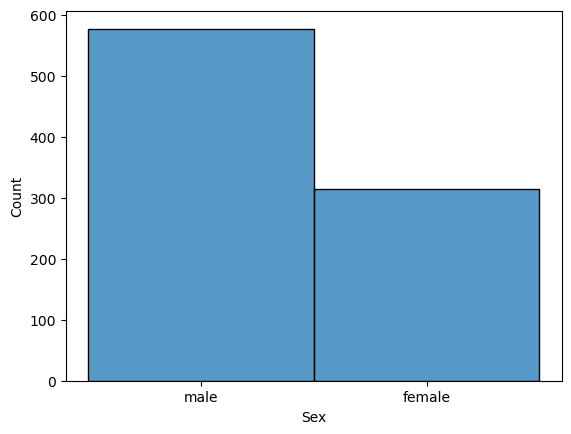

In [95]:

#This operation only maps values on the "Sex" column
df["Sex"] = df["Sex"].map({
    "male": "male",
    "m": "male",
    "m ": "male",
    "M": "male",
    "F": "female",
    "f": "female",
    "female": "female"
})
df["Sex"].unique()
sns.histplot(df['Sex'])

In [96]:
# inspect the correlation between Title and Survived
df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean()

Sex  Survived
0  female  0.742038
1    male  0.188908

In [97]:
df['Sex'].replace( 'female', 0,inplace=True)
df['Sex'].replace('male', 1,inplace=True)

# Parch SibSP

- Parch - Number of parents or childern
- SibSp - Number of siblings or spouse

In [98]:

print('Number of null Parch: ')
df['Parch'].isnull().sum()

Number of null Parch: 


0

In [99]:

print('Number of null SibSp: ')
df['SibSp'].isnull().sum()

Number of null SibSp: 


0

In [100]:

# inspect the correlation between Title and Survived
df[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean()

Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000

In [101]:
# inspect the correlation between Title and Survived
df[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean()

SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000

We can probably combine the two columns to create a family group

In [102]:

df['Family'] = df['SibSp'] + df['Parch'] + 1

# inspect the correlation between Family and Survived
df[['Family', 'Survived']].groupby(['Family'], as_index=False).mean()

Family  Survived
0       1  0.303538
1       2  0.552795
2       3  0.578431
3       4  0.724138
4       5  0.200000
5       6  0.136364
6       7  0.333333
7       8  0.000000
8      11  0.000000

# Embarked

In [103]:

print('Number of null Embarked: ')
df['Embarked'].isnull().sum()

Number of null Embarked: 


2

In [104]:
df[df['Embarked'].isnull()]

PassengerId  Survived  Pclass                                       Name  \
64            62         1       1                        Icard, Miss. Amelie   
833          830         1       1  Stone, Mrs. George Nelson (Martha Evelyn)   

     Sex Age  SibSp  Parch  Fare Cabin Embarked          OnboardTime Title  \
64     0  38      0      0  80.0   B28      NaN  1912-04-10 08:42:36  Miss   
833    0  62      0      0  80.0   B28      NaN  1912-04-10 09:11:06   Mrs   

     Master  Miss  Mr  Mrs  Others  Family  
64        0     1   0    0       0       1  
833       0     0   0    1       0       1

In [105]:
embarked_null = df[df['Embarked'].isnull()]
df['Embarked'] = df['Embarked'].replace(np.NaN, 'S')

In [106]:
df.loc[embarked_null.index]

PassengerId  Survived  Pclass                                       Name  \
64            62         1       1                        Icard, Miss. Amelie   
833          830         1       1  Stone, Mrs. George Nelson (Martha Evelyn)   

     Sex Age  SibSp  Parch  Fare Cabin Embarked          OnboardTime Title  \
64     0  38      0      0  80.0   B28        S  1912-04-10 08:42:36  Miss   
833    0  62      0      0  80.0   B28        S  1912-04-10 09:11:06   Mrs   

     Master  Miss  Mr  Mrs  Others  Family  
64        0     1   0    0       0       1  
833       0     0   0    1       0       1

In [107]:

# inspect the correlation between Embarked and Survived
df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean()

Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009

In [108]:

embarked_dummies = pd.get_dummies(df['Embarked'])
embarked_dummies

C  Q  S
0    0  0  1
1    1  0  0
2    0  0  1
3    0  0  1
4    0  0  1
..  .. .. ..
890  0  0  1
891  0  0  1
892  0  0  1
893  1  0  0
894  0  1  0

[891 rows x 3 columns]

In [109]:

df = pd.concat([df, embarked_dummies], axis=1)
df

PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
890          887         0       2   
891          888         1       1   
892          889         0       3   
893          890         1       1   
894          891         0       3   

                                                  Name  Sex  Age  SibSp  \
0                              Braund, Mr. Owen Harris    1   22      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...    0    -      1   
2                               Heikkinen, Miss. Laina    0   26      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)    0   na      1   
4                             Allen, Mr. William Henry    1   35      0   
..                                                 ...  ...  ...    ...   
890                              Montvila, Rev. Juozas    1   27      0   
891                       Graham, Miss. Margaret Edith    0   19      0   
892           Johnston, Miss. Catherine Helen "Carrie"    0  NaN      1   
893                              Behr, Mr. Karl Howell    1   26      0   
894                                Dooley, Mr. Patrick    1   32      0   

     Parch     Fare Cabin  ...   Title Master Miss  Mr  Mrs  Others  Family  \
0        0   7.2500   NaN  ...      Mr      0    0   1    0       0       2   
1        0  71.2833   C85  ...     Mrs      0    0   0    1       0       2   
2        0   7.9250   NaN  ...    Miss      0    1   0    0       0       1   
3        0  53.1000  C123  ...     Mrs      0    0   0    1       0       2   
4        0   8.0500   NaN  ...      Mr      0    0   1    0       0       1   
..     ...      ...   ...  ...     ...    ...  ...  ..  ...     ...     ...   
890      0  13.0000   NaN  ...  Others      0    0   0    0       1       1   
891      0  30.0000   B42  ...    Miss      0    1   0    0       0       1   
892      2  23.4500   NaN  ...    Miss      0    1   0    0       0       4   
893      0  30.0000  C148  ...      Mr      0    0   1    0       0       1   
894      0   7.7500   NaN  ...      Mr      0    0   1    0       0       1   

     C  Q  S  
0    0  0  1  
1    1  0  0  
2    0  0  1  
3    0  0  1  
4    0  0  1  
..  .. .. ..  
890  0  0  1  
891  0  0  1  
892  0  0  1  
893  1  0  0  
894  0  1  0  

[891 rows x 22 columns]

# Fare


In [110]:

print('Number of null values in fare:')
df['Fare'].isna().sum()

Number of null values in fare:


44

In [111]:

null_fare_df = df[df['Fare'].isna()]
null_fare_df.head()

PassengerId  Survived  Pclass                      Name  Sex  Age  SibSp  \
6             7         0       1   McCarthy, Mr. Timothy J    1   54      0   
20           20         1       3   Masselmani, Mrs. Fatima    0  NaN      0   
22           22         1       2     Beesley, Mr. Lawrence    1   34      0   
32           31         0       1  Uruchurtu, Don. Manuel E    1   40      0   
50           49         0       3       Samaan, Mr. Youssef    1  NaN      2   

    Parch  Fare Cabin  ...   Title Master Miss  Mr  Mrs  Others  Family  C  Q  \
6       0   NaN   E46  ...      Mr      0    0   1    0       0       1  0  0   
20      0   NaN   NaN  ...     Mrs      0    0   0    1       0       1  1  0   
22      0   NaN   D56  ...      Mr      0    0   1    0       0       1  0  0   
32      0   NaN   NaN  ...  Others      0    0   0    0       1       1  1  0   
50      0   NaN   NaN  ...      Mr      0    0   1    0       0       3  1  0   

    S  
6   1  
20  0  
22  1  
32  0  
50  0  

[5 rows x 22 columns]

In [112]:
#But we could also get the different mean per pclass 
grouped = df.groupby(['Pclass'])['Fare'].mean()
#And use those means to fill the null values
fare_mean = df['Pclass'].map(grouped)
#Fill the null using the fare of Pclass
df_mean_per_class = df.copy()
df_mean_per_class['Fare'].fillna(fare_mean, inplace=True)
# df_mean_per_class.loc[null_fare_df.index]
df['Fare'] = df_mean_per_class['Fare']
df.iloc[null_fare_df.index].head()

PassengerId  Survived  Pclass                         Name  Sex  Age  \
6             7         0       1      McCarthy, Mr. Timothy J    1   54   
21           21         0       2         Fynney, Mr. Joseph J    1   35   
23           23         1       3  McGowan, Miss. Anna "Annie"    0   15   
34           33         1       3     Glynn, Miss. Mary Agatha    0  NaN   
52           51         0       3   Panula, Master. Juha Niilo    1    7   

    SibSp  Parch       Fare Cabin  ...   Title Master Miss  Mr  Mrs  Others  \
6       0      0  81.907054   E46  ...      Mr      0    0   1    0       0   
21      0      0  26.000000   NaN  ...      Mr      0    0   1    0       0   
23      0      0   8.029200   NaN  ...    Miss      0    1   0    0       0   
34      0      0   7.750000   NaN  ...    Miss      0    1   0    0       0   
52      4      1  13.637039   NaN  ...  Master      1    0   0    0       0   

    Family  C  Q  S  
6        1  0  0  1  
21       1  0  0  1  
23       1  0  1  0  
34       1  0  1  0  
52       6  0  0  1  

[5 rows x 22 columns]

In [113]:

# inspect the mean Fare values for people who died and survived
df[['Fare', 'Survived']].groupby(['Survived'],as_index=False).mean()

Survived       Fare
0         0  21.982690
1         1  47.014141

/tmp/ipykernel_1763/2626798597.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True)


<Axes: >

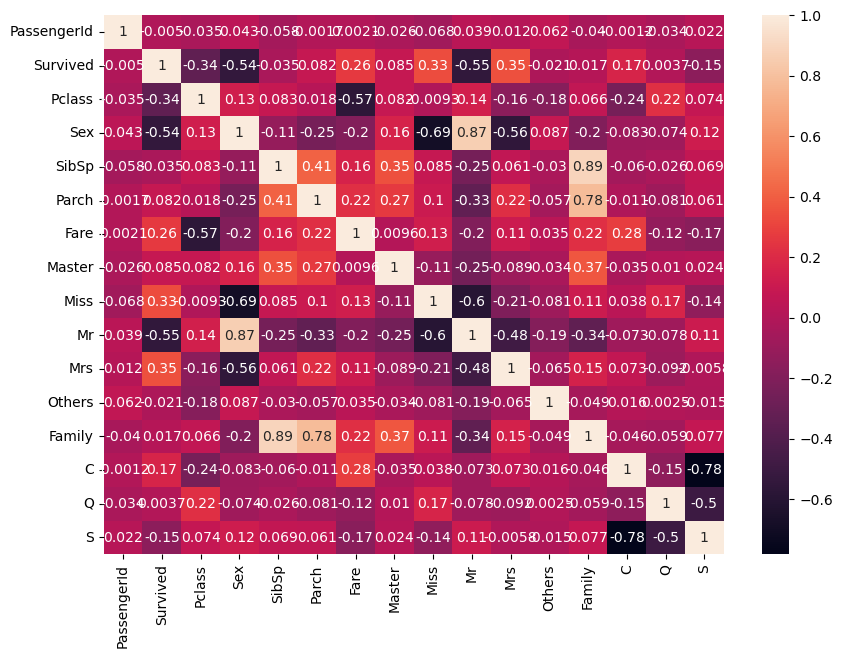

In [114]:
plt.figure(figsize=(10, 7))
sns.heatmap(df.corr(), annot=True)

# Random Forest

In [115]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Fare', 'Cabin', 'Embarked', 'OnboardTime', 'Title', 'Master',
       'Miss', 'Mr', 'Mrs', 'Others', 'Family', 'C', 'Q', 'S'],
      dtype='object')

In [116]:
from sklearn.model_selection import train_test_split

X = df.drop(['Survived', 'Name','Cabin', 'Embarked', 'OnboardTime', 'Age', 'PassengerId', 'Title'], axis=1)
y = df['Survived']



In [117]:

X.head()

Pclass  Sex  SibSp  Parch     Fare  Master  Miss  Mr  Mrs  Others  Family  \
0       3    1      1      0   7.2500       0     0   1    0       0       2   
1       1    0      1      0  71.2833       0     0   0    1       0       2   
2       3    0      0      0   7.9250       0     1   0    0       0       1   
3       1    0      1      0  53.1000       0     0   0    1       0       2   
4       3    1      0      0   8.0500       0     0   1    0       0       1   

   C  Q  S  
0  0  0  1  
1  1  0  0  
2  0  0  1  
3  0  0  1  
4  0  0  1

In [118]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalization 

In [119]:
X_train.describe()

Pclass         Sex       SibSp       Parch        Fare      Master  \
count  623.000000  623.000000  623.000000  623.000000  623.000000  623.000000   
mean     2.341894    0.658106    0.576244    0.386838   31.059964    0.049759   
std      0.819945    0.474725    1.216267    0.807692   46.934262    0.217622   
min      1.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      2.000000    0.000000    0.000000    0.000000    7.925000    0.000000   
50%      3.000000    1.000000    0.000000    0.000000   14.454200    0.000000   
75%      3.000000    1.000000    1.000000    0.000000   30.285400    0.000000   
max      3.000000    1.000000    8.000000    6.000000  512.329200    1.000000   

             Miss          Mr         Mrs      Others      Family           C  \
count  623.000000  623.000000  623.000000  623.000000  623.000000  623.000000   
mean     0.203852    0.590690    0.136437    0.019262    1.963082    0.176565   
std      0.403184    0.492102    0.343527    0.137554    1.731192    0.381607   
min      0.000000    0.000000    0.000000    0.000000    1.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    1.000000    0.000000   
50%      0.000000    1.000000    0.000000    0.000000    1.000000    0.000000   
75%      0.000000    1.000000    0.000000    0.000000    2.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000   11.000000    1.000000   

                Q           S  
count  623.000000  623.000000  
mean     0.088283    0.735152  
std      0.283933    0.441607  
min      0.000000    0.000000  
25%      0.000000    0.000000  
50%      0.000000    1.000000  
75%      0.000000    1.000000  
max      1.000000    1.000000

### For Fare


In [120]:
mean = X_train['Fare'].mean()
std = X_train['Fare'].std()

X_train['Fare'] = (X_train['Fare'] - mean) / std
X_train.describe()

Pclass         Sex       SibSp       Parch          Fare  \
count  623.000000  623.000000  623.000000  623.000000  6.230000e+02   
mean     2.341894    0.658106    0.576244    0.386838 -7.413367e-17   
std      0.819945    0.474725    1.216267    0.807692  1.000000e+00   
min      1.000000    0.000000    0.000000    0.000000 -6.617759e-01   
25%      2.000000    0.000000    0.000000    0.000000 -4.929227e-01   
50%      3.000000    1.000000    0.000000    0.000000 -3.538090e-01   
75%      3.000000    1.000000    1.000000    0.000000 -1.650316e-02   
max      3.000000    1.000000    8.000000    6.000000  1.025411e+01   

           Master        Miss          Mr         Mrs      Others      Family  \
count  623.000000  623.000000  623.000000  623.000000  623.000000  623.000000   
mean     0.049759    0.203852    0.590690    0.136437    0.019262    1.963082   
std      0.217622    0.403184    0.492102    0.343527    0.137554    1.731192   
min      0.000000    0.000000    0.000000    0.000000    0.000000    1.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    1.000000   
50%      0.000000    0.000000    1.000000    0.000000    0.000000    1.000000   
75%      0.000000    0.000000    1.000000    0.000000    0.000000    2.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000   11.000000   

                C           Q           S  
count  623.000000  623.000000  623.000000  
mean     0.176565    0.088283    0.735152  
std      0.381607    0.283933    0.441607  
min      0.000000    0.000000    0.000000  
25%      0.000000    0.000000    0.000000  
50%      0.000000    0.000000    1.000000  
75%      0.000000    0.000000    1.000000  
max      1.000000    1.000000    1.000000

In [121]:

mean = X_test['Fare'].mean()
std = X_test['Fare'].std()

X_test['Fare'] = (X_test['Fare'] - mean) / std
X_test.describe()

Pclass         Sex       SibSp       Parch          Fare  \
count  268.000000  268.000000  268.000000  268.000000  2.680000e+02   
mean     2.231343    0.623134    0.399254    0.369403 -1.176505e-16   
std      0.869062    0.485507    0.765061    0.803618  1.000000e+00   
min      1.000000    0.000000    0.000000    0.000000 -7.290567e-01   
25%      1.000000    0.000000    0.000000    0.000000 -5.531988e-01   
50%      3.000000    1.000000    0.000000    0.000000 -4.079729e-01   
75%      3.000000    1.000000    1.000000    0.000000 -3.441629e-02   
max      3.000000    1.000000    4.000000    5.000000  5.098482e+00   

           Master        Miss          Mr         Mrs      Others      Family  \
count  268.000000  268.000000  268.000000  268.000000  268.000000  268.000000   
mean     0.033582    0.212687    0.555970    0.160448    0.037313    1.768657   
std      0.180488    0.409973    0.497787    0.367707    0.189883    1.291947   
min      0.000000    0.000000    0.000000    0.000000    0.000000    1.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    1.000000   
50%      0.000000    0.000000    1.000000    0.000000    0.000000    1.000000   
75%      0.000000    0.000000    1.000000    0.000000    0.000000    2.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    7.000000   

                C           Q           S  
count  268.000000  268.000000  268.000000  
mean     0.216418    0.082090    0.701493  
std      0.412573    0.275015    0.458459  
min      0.000000    0.000000    0.000000  
25%      0.000000    0.000000    0.000000  
50%      0.000000    0.000000    1.000000  
75%      0.000000    0.000000    1.000000  
max      1.000000    1.000000    1.000000

## Base Random Forest Classifier

In [122]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))
base_report = classification_report(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.79      0.86      0.82       157
           1       0.77      0.68      0.72       111

    accuracy                           0.78       268
   macro avg       0.78      0.77      0.77       268
weighted avg       0.78      0.78      0.78       268



### Graphics

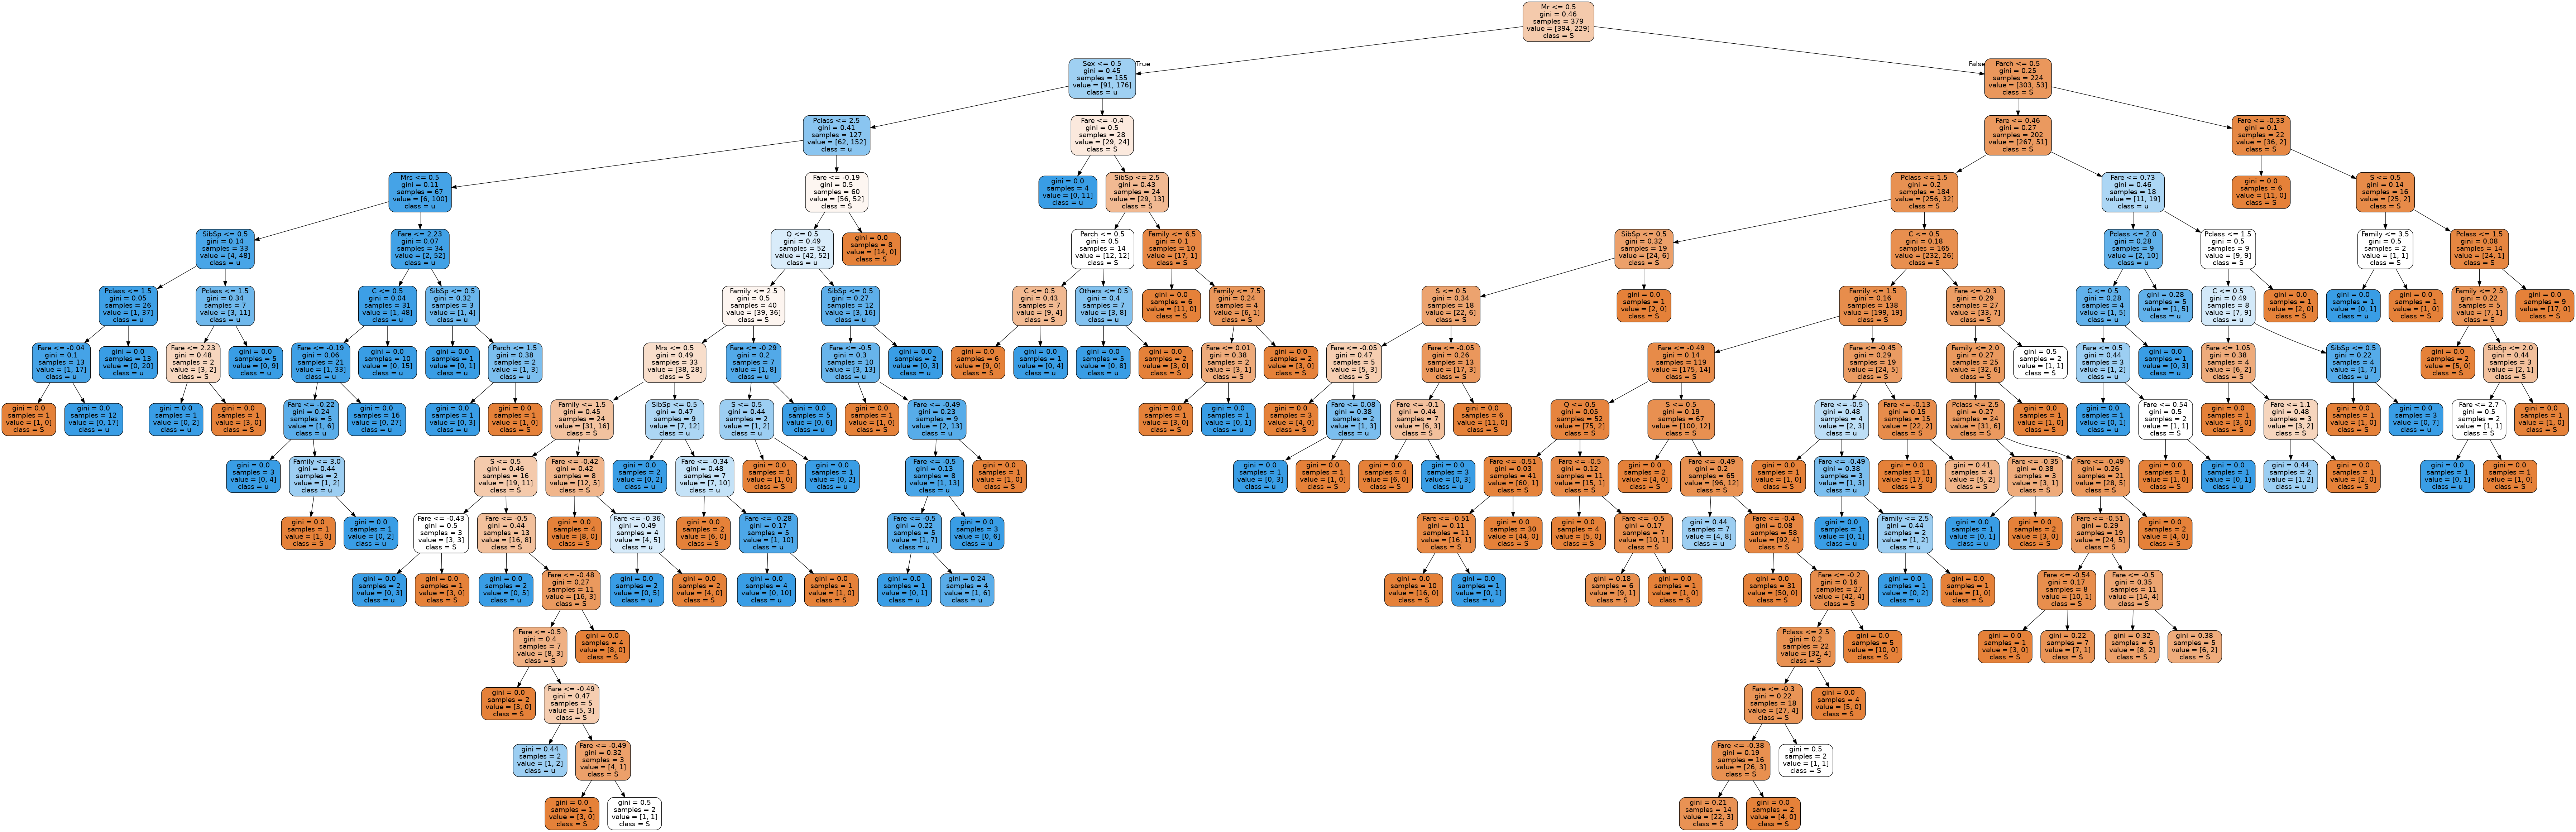

In [123]:
from sklearn.tree import export_graphviz

estimator = rf.estimators_[5]
# Get the column names of X and y
features = X_train.columns.to_list()
target = y_train.name

export_graphviz(estimator, out_file='tree.dot', 
                feature_names = features,
                class_names = target,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

## Hyperparameter tuning

In [124]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### Random Search

In [125]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# setting the param for random forest tuning
random_grid = {
    'n_estimators': n_estimators,
    'max_features': ['sqrt', 'log2', 'auto', None],
    'max_depth': max_depth,
    'max_leaf_nodes': [3, 6, 9],
    'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
    'bootstrap':[True, False],
    
}
random_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['sqrt', 'log2', 'auto', None],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110],
 'max_leaf_nodes': [3, 6, 9],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'bootstrap': [True, False]}

In [126]:
from sklearn.model_selection import RandomizedSearchCV
# Use the random grid to search for best hyperparameters
# First create the base model to tune

rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sq

[CV] END bootstrap=True, max_depth=10, max_features=None, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, max_features=None, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, max_features=None, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=50, max_features=None, max_leaf_nodes=9, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=50, max_features=None, max_leaf_nodes=9, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, max_depth=50, max_features=None, max_leaf_nodes=9, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END bootstrap=False, max_depth=110, max_features=None, max_leaf_n

/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=auto, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.4s


/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=auto, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.5s


/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=auto, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=110, max_features=log2, max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=   2.9s
[CV] END bootstrap=True, max_depth=60, max_features=None, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time=   3.2s
[CV] END bootstrap=False, max_depth=100, max_features=log2, max_leaf_nodes=9, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time=   3.9s
[CV] END bootstrap=False, max_depth=100, max_features=log2, max_leaf_nodes=9, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time=   3.9s
[CV] END bootstrap=False, max_depth=100, max_features=log2, max_leaf_nodes=9, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time=   3.7s
[CV] END bootstrap=True, max_depth=60, max_features=None, max

/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=log2, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   1.3s
[CV] END bootstrap=False, max_depth=30, max_features=log2, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   1.7s


/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=sqrt, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   3.5s
[CV] END bootstrap=False, max_depth=30, max_features=log2, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   1.5s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   3.6s
[CV] END bootstrap=False, max_depth=30, max_features=log2, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   1.5s


/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=sqrt, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   3.5s
[CV] END bootstrap=True, max_depth=110, max_features=auto, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   1.9s


/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=auto, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   1.9s


/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=auto, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   1.9s
[CV] END bootstrap=False, max_depth=40, max_features=None, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   1.7s


/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=40, max_features=None, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   1.7s
[CV] END bootstrap=False, max_depth=40, max_features=None, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   1.8s
[CV] END bootstrap=True, max_depth=80, max_features=auto, max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   1.4s


/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sq

[CV] END bootstrap=True, max_depth=80, max_features=auto, max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   1.5s
[CV] END bootstrap=True, max_depth=80, max_features=auto, max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   1.4s


/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=110, max_features=auto, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   1.6s
[CV] END bootstrap=True, max_depth=20, max_features=auto, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.9s


/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=110, max_features=auto, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   1.8s
[CV] END bootstrap=True, max_depth=20, max_features=auto, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   3.0s
[CV] END bootstrap=True, max_depth=20, max_features=auto, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   3.1s
[CV] END bootstrap=True, max_depth=50, max_features=None, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   1.4s
[CV] END bootstrap=False, max_depth=110, max_features=auto, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   2.2s
[CV] END bootstrap=True, max_depth=30, max_features=log2, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   2.6s
[CV] END bootstrap=True, max_depth=30, max_features=log2, max_leaf_n

/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=log2, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   2.6s


/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=None, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   1.4s
[CV] END bootstrap=True, max_depth=10, max_features=auto, max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   5.9s
[CV] END bootstrap=True, max_depth=50, max_features=None, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   1.7s
[CV] END bootstrap=True, max_depth=50, max_features=auto, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   1.2s
[CV] END bootstrap=True, max_depth=60, max_features=None, max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, max_depth=50, max_features=auto, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   1.4s
[CV] END bootstrap=True, max_depth=60, max_features=None, max_leaf_nodes=9,

/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=70, max_features=auto, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   2.1s


/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=80, max_features=log2, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=   5.3s
[CV] END bootstrap=True, max_depth=60, max_features=None, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time=   5.5s


/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=90, max_features=sqrt, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=10, n_estimators=1400; total time=   5.0s
[CV] END bootstrap=False, max_depth=70, max_features=auto, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   2.2s
[CV] END bootstrap=True, max_depth=60, max_features=None, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time=   5.8s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=   1.1s


/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=   1.1s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=   1.0s
[CV] END bootstrap=False, max_depth=70, max_features=auto, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   1.8s


/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=90, max_features=sqrt, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=10, n_estimators=1400; total time=   5.7s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=10, n_estimators=1400; total time=   6.0s


/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=60, max_features=None, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time=   6.9s
[CV] END bootstrap=True, max_depth=30, max_features=auto, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time=   5.4s


/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time=   5.5s
[CV] END bootstrap=True, max_depth=30, max_features=auto, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time=   5.4s
[CV] END bootstrap=False, max_depth=70, max_features=auto, max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=2, n_estimators=1800; total time=   5.3s
[CV] END bootstrap=False, max_depth=70, max_features=auto, max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=2, n_estimators=1800; total time=   5.6s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time=   6.7s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time=   6.9s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, max_leaf_n

/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=None, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; total time=   3.7s


/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=60, max_features=auto, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   1.7s


/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=60, max_features=auto, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   1.9s


/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=60, max_features=auto, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   1.8s


/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=2, n_estimators=1600; total time=   5.7s


/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=auto, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=   3.9s
[CV] END bootstrap=True, max_depth=20, max_features=None, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time=   8.5s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=2, n_estimators=1600; total time=   7.1s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=2, n_estimators=1600; total time=   7.5s


/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sq

[CV] END bootstrap=True, max_depth=110, max_features=auto, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=   3.9s
[CV] END bootstrap=True, max_depth=20, max_features=None, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time=   9.2s
[CV] END bootstrap=True, max_depth=40, max_features=auto, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, max_depth=40, max_features=auto, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=20, max_features=None, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time=   8.8s
[CV] END bootstrap=True, max_depth=40, max_features=auto, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=110, max_features=auto, max_leaf_

/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=100, max_features=log2, max_leaf_nodes=9, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=   1.9s


/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=log2, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   1.4s


/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=log2, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   1.5s
[CV] END bootstrap=True, max_depth=30, max_features=log2, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   1.5s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=2, n_estimators=1400; total time=   3.4s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=2, n_estimators=1400; total time=   3.4s
[CV] END bootstrap=False, max_depth=110, max_features=auto, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=10, n_estimators=1200; total time=   2.6s
[CV] END bootstrap=False, max_depth=110, max_features=auto, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=10, n_estimators=1200; total time=   2.6s
[CV] END bootstrap=False, max_depth=100, max_features=log2, max_

/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sq

[CV] END bootstrap=False, max_depth=100, max_features=log2, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=110, max_features=auto, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=10, n_estimators=1200; total time=   2.5s


/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=110, max_features=auto, max_leaf_nodes=9, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=   1.5s
[CV] END bootstrap=False, max_depth=110, max_features=auto, max_leaf_nodes=9, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=   1.6s


/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=110, max_features=auto, max_leaf_nodes=9, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=   1.7s
[CV] END bootstrap=False, max_depth=100, max_features=None, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time=   4.6s
[CV] END bootstrap=False, max_depth=100, max_features=None, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time=   4.7s
[CV] END bootstrap=False, max_depth=40, max_features=auto, max_leaf_nodes=6, min_samples_leaf=2, min_samples_split=2, n_estimators=1600; total time=   3.5s
[CV] END bootstrap=False, max_depth=40, max_features=auto, max_leaf_nodes=6, min_samples_leaf=2, min_samples_split=2, n_estimators=1600; total time=   3.5s
[CV] END bootstrap=False, max_depth=100, max_features=None, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time=   4.8s


/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=40, max_features=auto, max_leaf_nodes=6, min_samples_leaf=2, min_samples_split=2, n_estimators=1600; total time=   4.0s


/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=log2, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=10, n_estimators=1400; total time=   3.3s


/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=None, max_leaf_nodes=6, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=   5.9s
[CV] END bootstrap=False, max_depth=10, max_features=log2, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=10, n_estimators=1400; total time=   3.6s
[CV] END bootstrap=False, max_depth=10, max_features=log2, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=10, n_estimators=1400; total time=   3.7s
[CV] END bootstrap=False, max_depth=50, max_features=None, max_leaf_nodes=6, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=   6.7s
[CV] END bootstrap=False, max_depth=30, max_features=log2, max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   1.1s
[CV] END bootstrap=True, max_depth=80, max_features=auto, max_leaf_nodes=6, min_samples_leaf=2, min_samples_split=2, n_estimators=1400; total time=   4.7s
[CV] END bootstrap=False, max_depth=30, max_features=log2, ma

/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=None, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   3.2s
[CV] END bootstrap=True, max_depth=80, max_features=auto, max_leaf_nodes=6, min_samples_leaf=2, min_samples_split=2, n_estimators=1400; total time=   5.1s


/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=80, max_features=auto, max_leaf_nodes=6, min_samples_leaf=2, min_samples_split=2, n_estimators=1400; total time=   6.3s
[CV] END bootstrap=True, max_depth=20, max_features=log2, max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time=   4.6s
[CV] END bootstrap=True, max_depth=40, max_features=auto, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   3.3s
[CV] END bootstrap=True, max_depth=40, max_features=auto, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   3.2s
[CV] END bootstrap=True, max_depth=20, max_features=log2, max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time=   5.7s
[CV] END bootstrap=True, max_depth=20, max_features=log2, max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time=   5.9s
[CV] END bootstrap=True, max_depth=40, max_features=auto, max_leaf_no

/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=None, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=   3.4s


/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=sqrt, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=2, n_estimators=1200; total time=   3.9s


/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=sqrt, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=2, n_estimators=1200; total time=   3.8s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=2, n_estimators=1200; total time=   4.5s
[CV] END bootstrap=False, max_depth=20, max_features=log2, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=2, n_estimators=1600; total time=   4.8s
[CV] END bootstrap=False, max_depth=20, max_features=log2, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=2, n_estimators=1600; total time=   4.2s
[CV] END bootstrap=False, max_depth=80, max_features=auto, max_leaf_nodes=9, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=   4.3s
[CV] END bootstrap=False, max_depth=20, max_features=log2, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=2, n_estimators=1600; total time=   4.7s
[CV] END bootstrap=False, max_depth=80, max_features=auto, max_l

/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=60, max_features=log2, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=2, n_estimators=1200; total time=   4.7s


/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=None, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=2, n_estimators=1200; total time=   3.9s


/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=None, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=2, n_estimators=1200; total time=   4.2s
[CV] END bootstrap=True, max_depth=110, max_features=auto, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=   3.7s
[CV] END bootstrap=True, max_depth=10, max_features=None, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=2, n_estimators=1200; total time=   4.8s
[CV] END bootstrap=True, max_depth=40, max_features=None, max_leaf_nodes=9, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=   5.9s
[CV] END bootstrap=True, max_depth=40, max_features=None, max_leaf_nodes=9, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=   5.6s
[CV] END bootstrap=True, max_depth=40, max_features=None, max_leaf_nodes=9, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=   6.8s
[CV] END bootstrap=True, max_depth=110, max_features=auto, max_leaf_n

/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=None, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=10, n_estimators=1400; total time=   6.0s
[CV] END bootstrap=True, max_depth=10, max_features=None, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=10, n_estimators=1400; total time=   6.2s


/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   7.7s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, max_leaf_nodes=6, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=   3.3s
[CV] END bootstrap=True, max_depth=10, max_features=None, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=10, n_estimators=1400; total time=   7.2s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   9.5s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   8.6s
[CV] END bootstrap=False, max_depth=110, max_features=auto, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=10, n_estimators=1600; total time=   4.2s
[CV] END bootstrap=False, max_depth=50, max_features=None, max_l

/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=110, max_features=auto, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=10, n_estimators=1600; total time=   4.1s
[CV] END bootstrap=False, max_depth=110, max_features=auto, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=10, n_estimators=1600; total time=   4.1s


/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=None, max_leaf_nodes=9, min_samples_leaf=4, min_samples_split=5, n_estimators=600; total time=   2.0s


/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=None, max_leaf_nodes=9, min_samples_leaf=4, min_samples_split=5, n_estimators=600; total time=   1.7s


/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=auto, max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   0.9s


/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=auto, max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   0.9s
[CV] END bootstrap=False, max_depth=90, max_features=auto, max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   0.9s
[CV] END bootstrap=True, max_depth=80, max_features=None, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   6.3s
[CV] END bootstrap=True, max_depth=80, max_features=None, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   6.5s
[CV] END bootstrap=True, max_depth=80, max_features=None, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   6.2s


/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=log2, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; total time=   2.7s


/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=log2, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; total time=   2.7s
[CV] END bootstrap=True, max_depth=90, max_features=auto, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1800; total time=   5.3s
[CV] END bootstrap=True, max_depth=90, max_features=auto, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1800; total time=   5.2s
[CV] END bootstrap=True, max_depth=90, max_features=auto, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1800; total time=   5.4s
[CV] END bootstrap=False, max_depth=90, max_features=auto, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   1.9s
[CV] END bootstrap=False, max_depth=90, max_features=auto, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   2.0s
[CV] END bootstrap=True, max_depth=60, max_features=None, max_leaf

/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sq

[CV] END bootstrap=True, max_depth=60, max_features=None, max_leaf_nodes=6, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   1.3s
[CV] END bootstrap=True, max_depth=60, max_features=None, max_leaf_nodes=6, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   1.2s
[CV] END bootstrap=True, max_depth=80, max_features=None, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   1.2s
[CV] END bootstrap=True, max_depth=80, max_features=None, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   1.2s
[CV] END bootstrap=True, max_depth=80, max_features=None, max_leaf_nodes=9, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   1.3s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1400; total time=   3.2s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, max_leaf_no

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': ['sqrt', 'log2', 'auto',
                                                         None],
                                        'max_leaf_nodes': [3, 6, 9],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [127]:
rf_random.best_params_

{'n_estimators': 1200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_leaf_nodes': 9,
 'max_features': None,
 'max_depth': 10,
 'bootstrap': True}

In [128]:
best_random = rf_random.best_estimator_
best_random.fit(X_train, y_train)

y_pred_random = best_random.predict(X_test)

print(classification_report(y_test, y_pred_random))
random_report = classification_report(y_test, y_pred_random)


              precision    recall  f1-score   support

           0       0.82      0.90      0.85       157
           1       0.83      0.71      0.77       111

    accuracy                           0.82       268
   macro avg       0.82      0.80      0.81       268
weighted avg       0.82      0.82      0.82       268



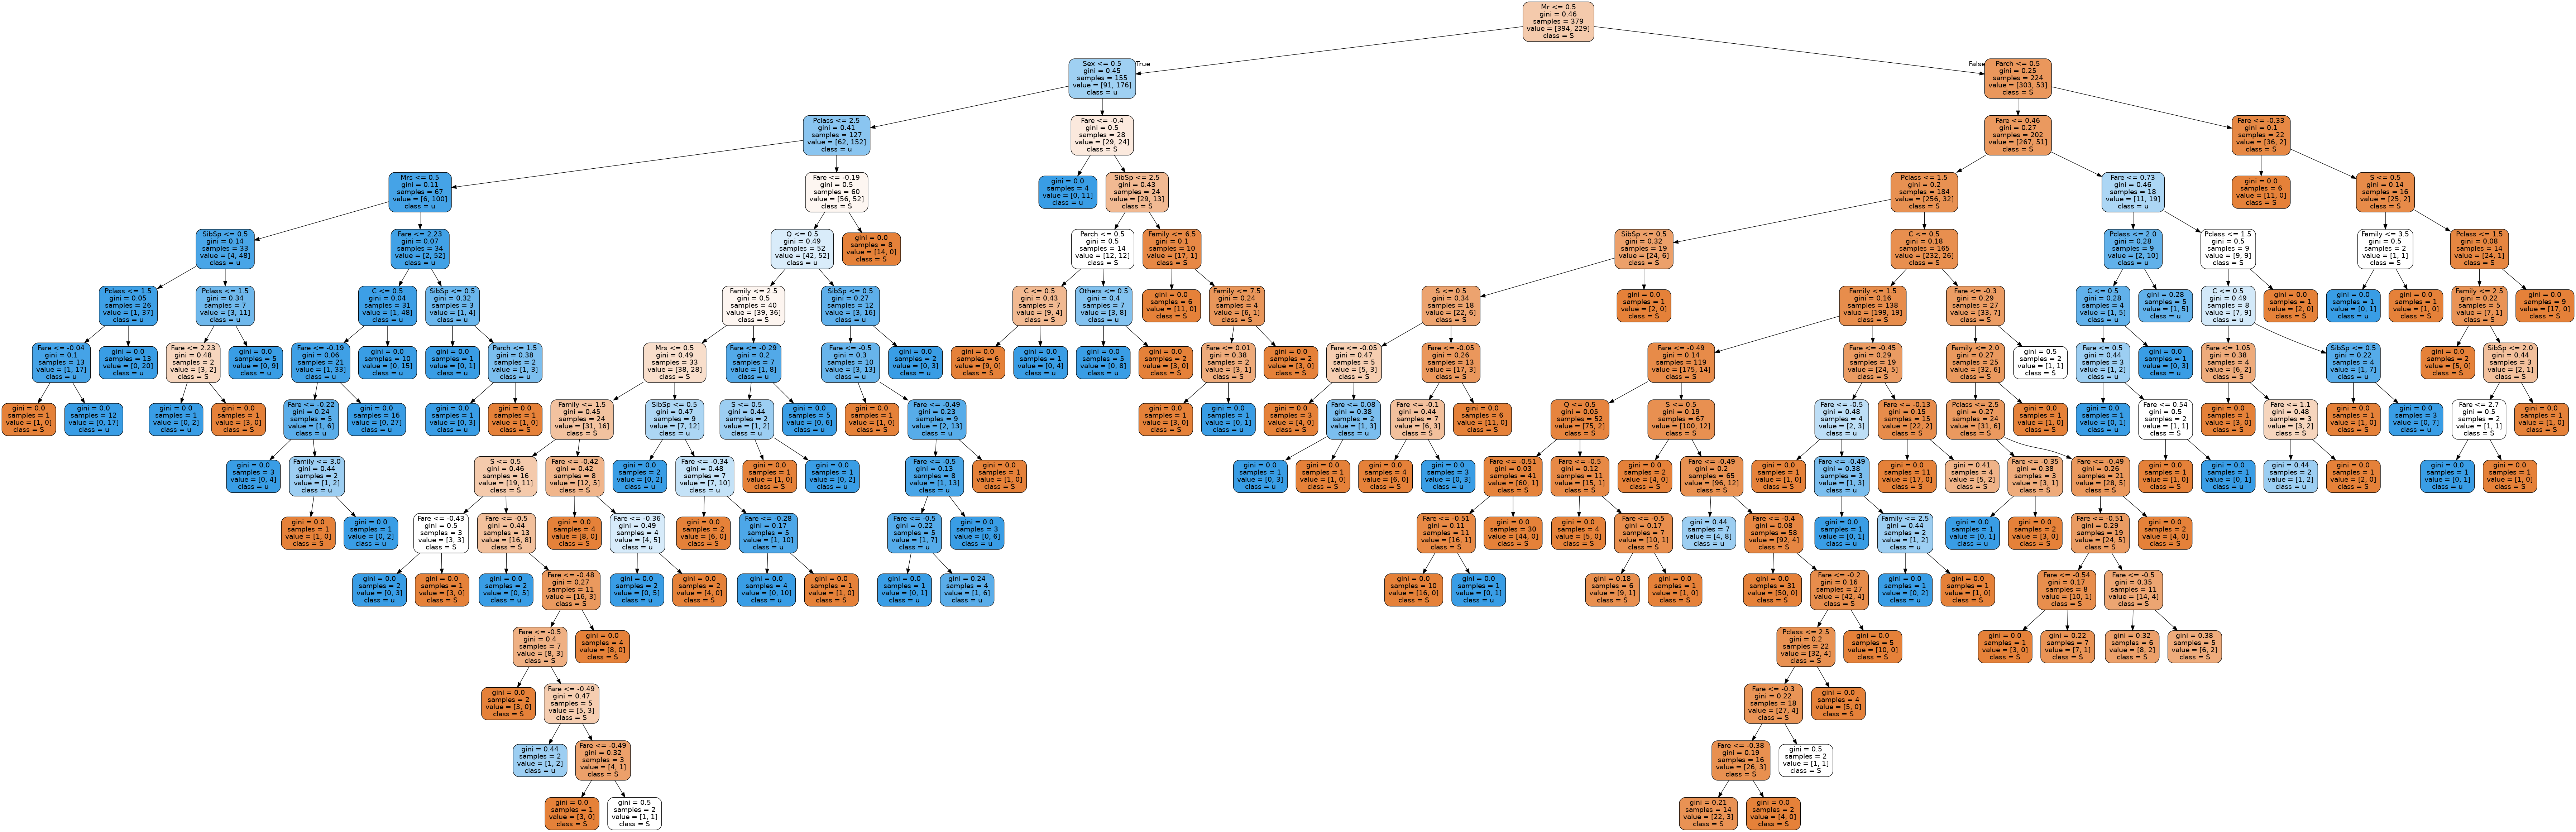

In [129]:
estimator = best_random.estimators_[5]
# Get the column names of X and y
features = X_train.columns.to_list()
target = y_train.name

export_graphviz(estimator, out_file='tree_random.dot', 
                feature_names = features,
                class_names = target,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree_random.png'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree_random.png')

### Grid Search

In [130]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [None, 0, 2],
    'max_leaf_nodes':[5,9,13],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [8, 12, 16],
    'n_estimators': [200, 300,400, 500, 1000]
}
# Create a new model
rf_new = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf_new, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [131]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 1620 candidates, totalling 4860 fits
[CV] END bootstrap=True, max_depth=80, max_features=None, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=8, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=80, max_features=None, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=8, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=80, max_features=None, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=8, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=80, max_features=None, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=8, n_estimators=300; total time=   0.8s
[CV] END bootstrap=True, max_depth=80, max_features=None, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=8, n_estimators=300; total time=   0.8s
[CV] END bootstrap=True, max_depth=80, max_features=None, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=8, n_estimators=300; total time=   0.8s
[CV] END bo

/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1620 fits failed out of a total of 4860.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
722 fits failed with the following error:
Traceback (most recent call last):
  File "/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/home/iggy/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/base.py", line 600, in _validate

{'bootstrap': True,
 'max_depth': 110,
 'max_features': None,
 'max_leaf_nodes': 9,
 'min_samples_leaf': 2,
 'min_samples_split': 12,
 'n_estimators': 200}

In [132]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 110,
 'max_features': None,
 'max_leaf_nodes': 9,
 'min_samples_leaf': 2,
 'min_samples_split': 12,
 'n_estimators': 200}

In [133]:
rf_random.best_params_

{'n_estimators': 1200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_leaf_nodes': 9,
 'max_features': None,
 'max_depth': 10,
 'bootstrap': True}

In [134]:

best_grid = grid_search.best_estimator_
best_grid.fit(X_train, y_train)

y_pred_grid = best_random.predict(X_test)

print(classification_report(y_test, y_pred_grid))
grid_report = classification_report(y_test, y_pred_grid)

              precision    recall  f1-score   support

           0       0.82      0.90      0.85       157
           1       0.83      0.71      0.77       111

    accuracy                           0.82       268
   macro avg       0.82      0.80      0.81       268
weighted avg       0.82      0.82      0.82       268



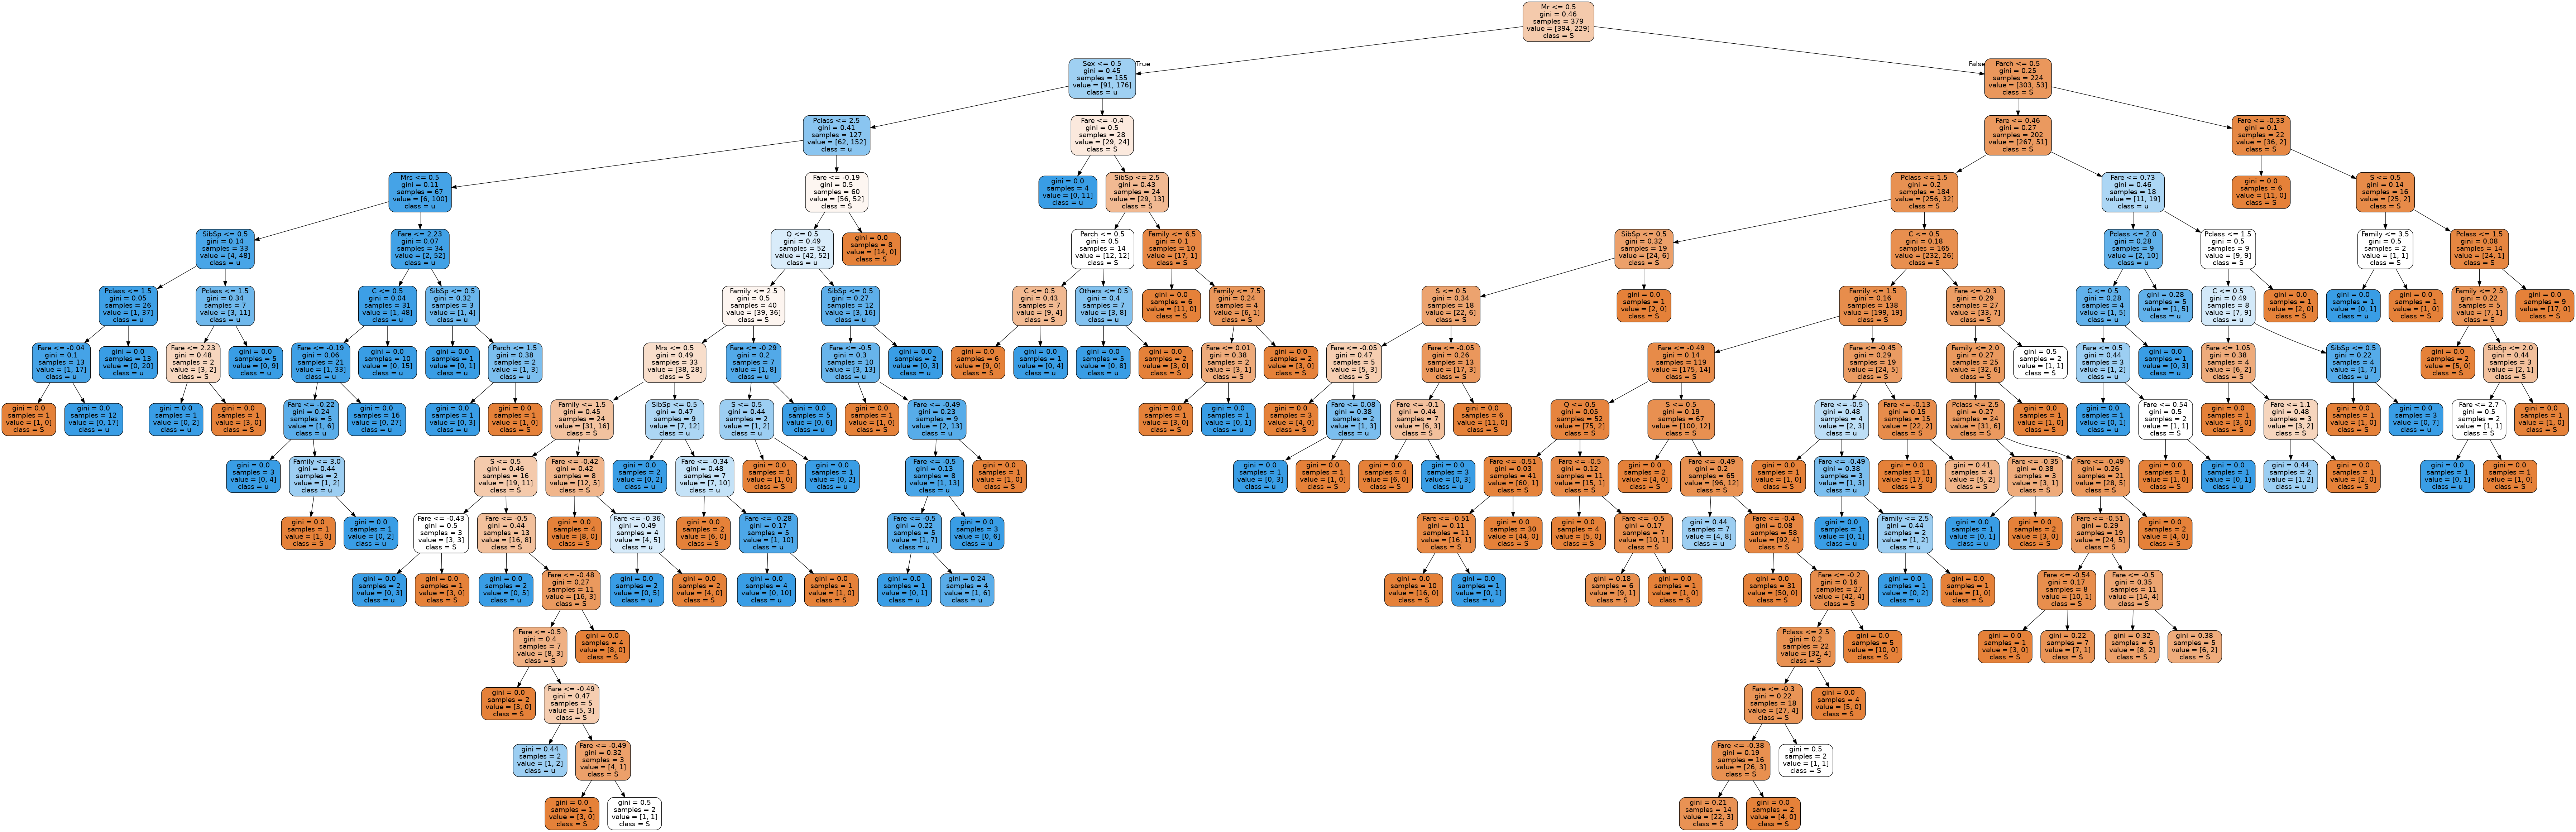

In [135]:

estimator = best_grid.estimators_[5]
# Get the column names of X and y
features = X_train.columns.to_list()
target = y_train.name

export_graphviz(estimator, out_file='tree_grid.dot', 
                feature_names = features,
                class_names = target,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree_grid.png'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree_grid.png')

## Comparing results

In [136]:
print('Base Report:')
print(base_report)
print('*'*60)
print('Random Report:')
print(random_report)
print('*'*60)
print('Grid Report:')
print(grid_report)
print('*'*60)

Base Report:
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       157
           1       0.77      0.68      0.72       111

    accuracy                           0.78       268
   macro avg       0.78      0.77      0.77       268
weighted avg       0.78      0.78      0.78       268

************************************************************
Random Report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.85       157
           1       0.83      0.71      0.77       111

    accuracy                           0.82       268
   macro avg       0.82      0.80      0.81       268
weighted avg       0.82      0.82      0.82       268

************************************************************
Grid Report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.85       157
           1       0.83      0.71      0.77       111

    accuracy       